In [1]:
# create strategy

from dijkies.executors import ExchangeAssetClient
from dijkies.strategy import Strategy

from ta.momentum import RSIIndicator
from pandas.core.frame import DataFrame as PandasDataFrame

from dijkies.executors import BacktestExchangeAssetClient, State

from dijkies.data_pipeline import DataPipeline, NoDataPipeline


class RSIStrategy(Strategy):
    analysis_dataframe_size_in_minutes = 60*24*30

    def __init__(
        self,
        executor: ExchangeAssetClient,
        lower_threshold: float,
        higher_threshold: float,
    ) -> None:
        self.lower_threshold = lower_threshold
        self.higher_threshold = higher_threshold
        super().__init__(executor)

    def execute(self, candle_df: PandasDataFrame) -> None:
        candle_df["momentum_rsi"] = RSIIndicator(candle_df.close).rsi()

        previous_candle = candle_df.iloc[-2]
        current_candle = candle_df.iloc[-1]

        is_buy_signal = (
            previous_candle.momentum_rsi > self.lower_threshold
            and current_candle.momentum_rsi < self.lower_threshold
        )

        if is_buy_signal:
            self.executor.place_market_buy_order(
                self.executor.state.base,
                self.executor.state.quote_available,
            )

        is_sell_signal = (
            previous_candle.momentum_rsi < self.higher_threshold
            and current_candle.momentum_rsi > self.higher_threshold
        )

        if is_sell_signal:
            self.executor.place_market_sell_order(
                self.executor.state.base,
                self.executor.state.base_available,
            )

    def get_data_pipeline(self) -> DataPipeline:
        """
        Implement this metho
        """
        return NoDataPipeline()

In [ ]:
#get data for backtesting

from dijkies.exchange_market_api import BitvavoMarketAPI

bitvavo_market_api = BitvavoMarketAPI()

candle_df = bitvavo_market_api.get_candles()

2026-01-04 21:03:32,469 [INFO] dijkies.logger: 
            📮 Fetching 2 chunks in parallel (interval=1h,
            max_workers=4)
            
2026-01-04 21:03:32,705 [INFO] dijkies.logger: ✅ Retrieved 1438 candles successfully.


In [3]:
# do backtest

fee_limit_order = 0.0015
fee_market_order = 0.0025

start_investment_base = 0
start_investment_quote = 1000

state = State(
    base="XRP",
    total_base=start_investment_base,
    total_quote=start_investment_quote
)

executor = BacktestExchangeAssetClient(
    state,
    fee_limit_order=fee_limit_order,
    fee_market_order=fee_market_order
)

strategy = RSIStrategy(
    executor,
    35,
    65,
)

results = strategy.backtest(candle_df)

/var/folders/r8/xj9tndfs6tjb0bh2cxnqtzt40000gn/T/ipykernel_46071/569121822.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candle_df["momentum_rsi"] = RSIIndicator(candle_df.close).rsi()
/var/folders/r8/xj9tndfs6tjb0bh2cxnqtzt40000gn/T/ipykernel_46071/569121822.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candle_df["momentum_rsi"] = RSIIndicator(candle_df.close).rsi()
/var/folders/r8/xj9tndfs6tjb0bh2cxnqtzt40000gn/T/ipykernel_46071/569121822.py:28: SettingWithCopyWarning: 
A value is trying to 

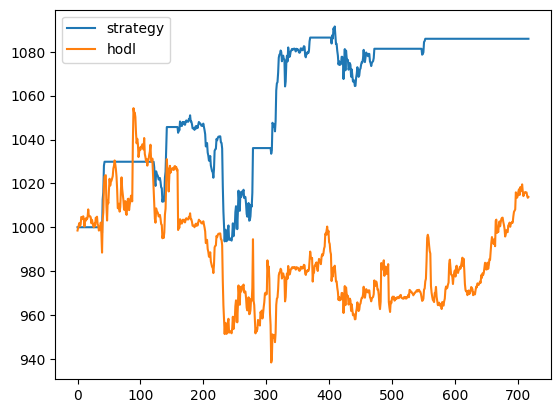

In [4]:
import matplotlib.pyplot as plt

results.total_value_strategy.plot(label = "strategy")
results.total_value_hodl.plot(label = "hodl")
plt.legend()
plt.show()